# Projet 6 : Classifiez automatiquement des biens de consommation

# Problématique
La classification manuelle des produits selon leur catégorie est difficile et enclin à des erreurs.
# Objectif

L'objectif est ici de construire et d'analyser des graphiques de clustering afin d’en déduire ou pas, à l’aide des descriptions ou des images, la faisabilité de regrouper automatiquement des produits de même catégorie.
Il sera ensuite question de réaliser une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters.


# Source des données
Le dataset utilisé pour ce projet est "flipkart_com-ecommerce_sample_1050". Il contient des informations sur 1050 produits vendus sur Flipkart, un site de e-commerce en Inde.

# Sommaire:
-  1 - Librairies
-  2 - Jeu de données
-  3 - EDA
-  4 - Prétraitement ds images
-  5 - Extraction de features (BoVW)
     - SIFT
     - Réduction de dimension T-SNE 
     - Kmeans + ARI.
     - Analyse graphique




# 1 - Librairies

In [1]:
 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import pickle
import os
import time
import random

# Traitement images
import PIL
from PIL import Image, ImageOps, ImageFilter
import cv2
import imghdr

from scipy.ndimage import gaussian_filter

import warnings
warnings.filterwarnings('ignore')


# 2 - Jeu de données


In [2]:
cleaned_df = pd.read_csv('cleaned_df.csv')

In [3]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               1050 non-null   int64 
 1   uniq_id                  1050 non-null   object
 2   image                    1050 non-null   object
 3   clean_product_name       1050 non-null   object
 4   clean_description        1050 non-null   object
 5   clean_categories         1050 non-null   object
 6   product_and_description  1050 non-null   object
dtypes: int64(1), object(6)
memory usage: 57.5+ KB


In [4]:
cleaned_df.drop(columns=['Unnamed: 0', 'uniq_id'], inplace=True)

In [5]:
cleaned_df = cleaned_df.rename(columns={'clean_product_name': 'product_name', 
                                        'clean_description': 'description', 
                                        'clean_categories': "categorie"})

cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   image                    1050 non-null   object
 1   product_name             1050 non-null   object
 2   description              1050 non-null   object
 3   categorie                1050 non-null   object
 4   product_and_description  1050 non-null   object
dtypes: object(5)
memory usage: 41.1+ KB


In [7]:
image_df = cleaned_df[["image", "categorie"]].copy()


In [8]:
image_df.shape

(1050, 2)

In [9]:
image_df.head()

,image,categorie
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing


- ### Accès aux images

In [10]:
image_path = '/Users/danongohou/Desktop/P6/Images/'


- ### Liaison des images à leurs identifiants

In [11]:
image_df['image_loc'] = [image_path + row for row in image_df['image']]

- ### Dataset utile (image)

In [12]:
image_df = image_df[["image", 'image_loc', "categorie"]]
image_df.head()

,image,image_loc,categorie
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6/Images/55b85ea15a...,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6/Images/7b72c92c2f...,baby care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6/Images/64d5d4a258...,baby care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6/Images/d4684dcdc7...,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6/Images/6325b6870c...,home furnishing


In [13]:
image_df.to_csv("image_data.csv")

# 3 - EDA 

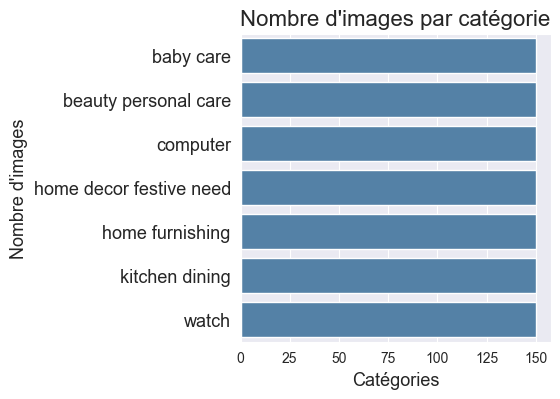

In [14]:
nb_image_categorie = image_df.groupby('categorie').agg({'image' : 'count'})

plt.figure(figsize=(4, 4))
sns.set_style('darkgrid')
sns.barplot(y=nb_image_categorie.index, x=nb_image_categorie.image,
            data=nb_image_categorie, color='SteelBlue')
plt.title('Nombre d\'images par catégorie', fontsize=16)
plt.xlabel('Catégories', fontsize=13)
plt.ylabel('Nombre d\'images', fontsize=13)
plt.yticks(fontsize=13)

plt.show()

- ### Voir quelques images

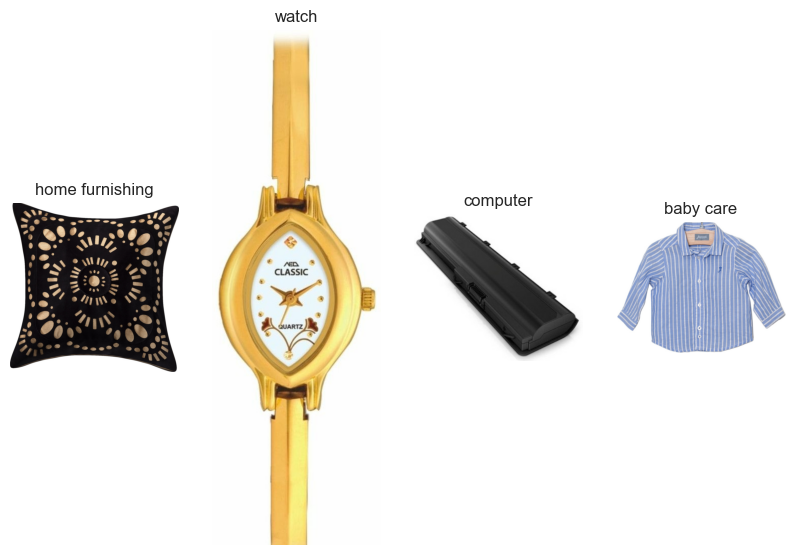

In [15]:
# Sélection de 4 images au hasard
import random

# Sélectionner 4 images aléatoires
random_images = random.sample(list(image_df.index), 4)

# Afficher les images
fig, axs = plt.subplots(1, 4, figsize=(10,10))
for i, idx in enumerate(random_images):
    img = plt.imread(image_df.loc[idx, 'image_loc'])
    category = image_df.loc[idx, 'categorie']
    axs[i].imshow(img)
    axs[i].set_title(category)
    axs[i].axis('off')
plt.show()


- ### Largeur des images

<Figure size 600x400 with 0 Axes>

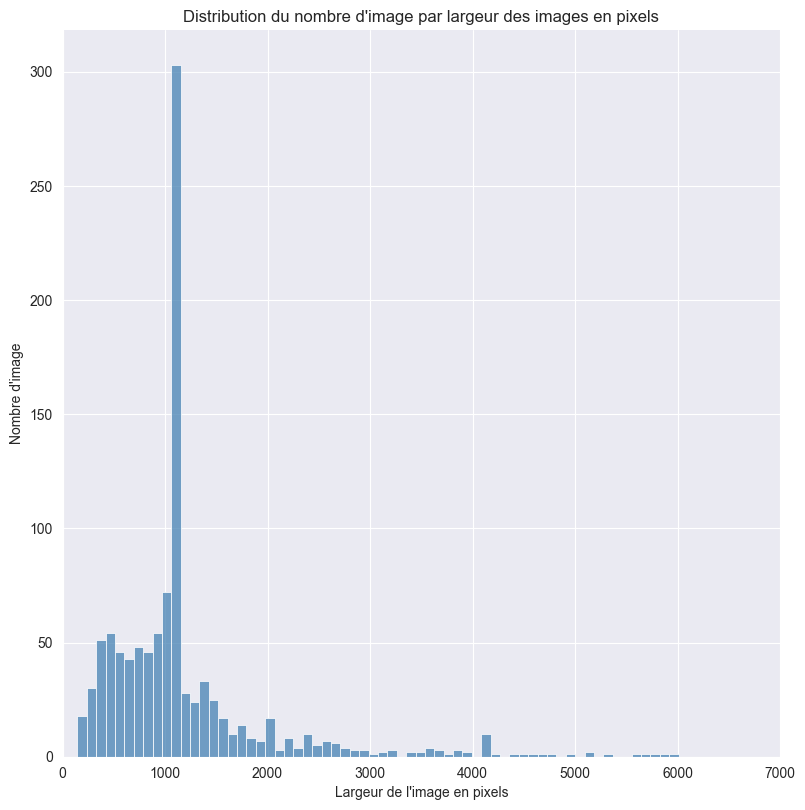

In [16]:
# Largeur des images
image_df['Largeur_image'] = [Image.open(row).size[0] for row in image_df['image_loc']]

plt.figure(figsize=(6, 4))
# Répartition du nombre d'images par taille de l'image en pixel
sns.displot(image_df['Largeur_image'], color='SteelBlue', height=8)
plt.title('Distribution du nombre d\'image par largeur des images en pixels')
plt.xlim(0, 7000)
plt.xlabel('Largeur de l\'image en pixels')
plt.ylabel('Nombre d\'image')
plt.show()

- ### Hauteur des images

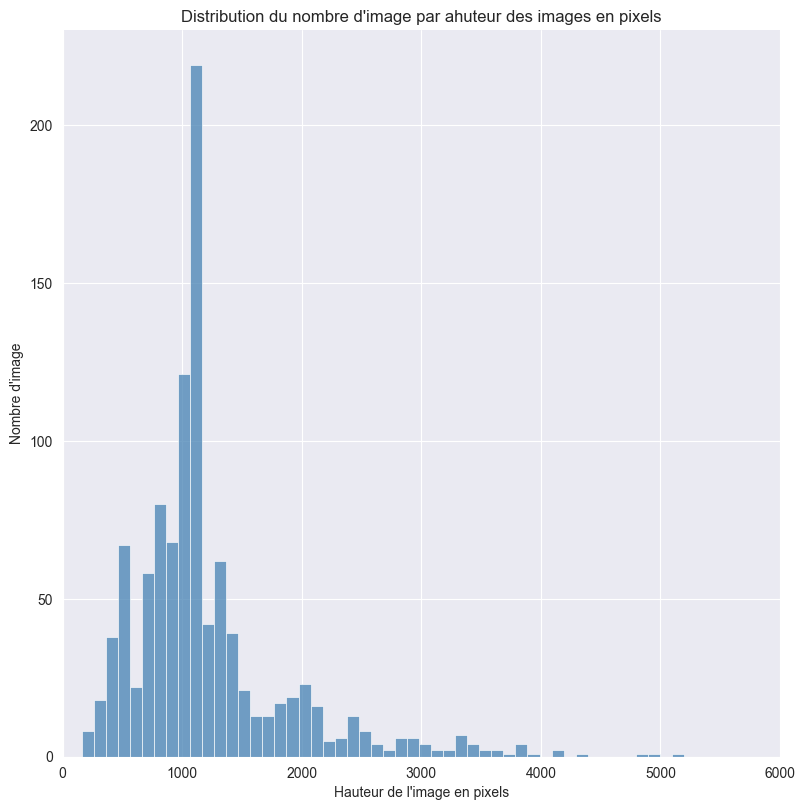

In [17]:
# Hauteur des images
image_df['Hauteur_image'] = [Image.open(row).size[1] for row in image_df['image_loc']]

# Répartition du nombre d'images par taille de l'image en pixel
sns.displot(image_df['Hauteur_image'], color='SteelBlue', height=8)
plt.title('Distribution du nombre d\'image par ahuteur des images en pixels')
plt.xlim(0, 6000)
plt.xlabel('Hauteur de l\'image en pixels')
plt.ylabel('Nombre d\'image')
plt.show()

- ### Taille des images

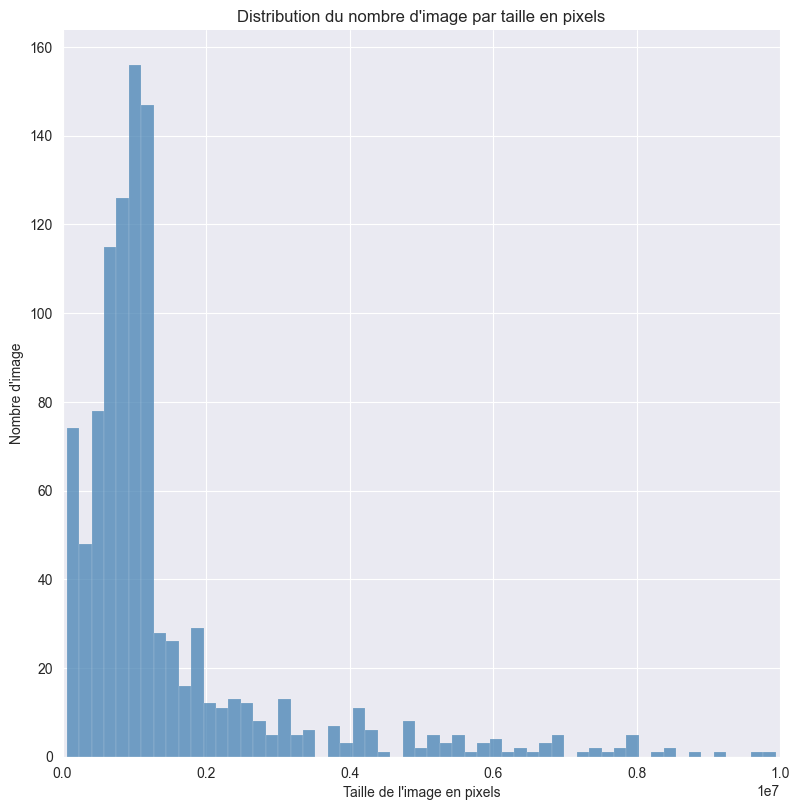

In [18]:
# Taille des images
image_df['Taille_image'] = [(Image.open(row).size[0] * Image.open(row).size[1])
                      for row in image_df['image_loc']]

# Répartition du nombre d'images par taille de l'image en pixel
sns.displot(image_df['Taille_image'], color='SteelBlue', height=8)
plt.title('Distribution du nombre d\'image par taille en pixels')
plt.xlim(0, 10000000)
plt.xlabel('Taille de l\'image en pixels')
plt.ylabel('Nombre d\'image')
plt.show()



In [12]:

image_df = pd.read_csv('image_data.csv')

In [19]:
from PIL import Image
import pandas as pd

# Initialiser un dictionnaire pour stocker les comptes de format
format_counts = {}

# Boucle à travers chaque image et compter le format
for index, row in image_df.iterrows():
    image_path = row['image_loc']
    with Image.open(image_path) as img:
        format_counts[img.format] = format_counts.get(img.format, 0) + 1

# Convertir le dictionnaire en DataFrame et afficher
format_counts_df = pd.DataFrame.from_dict(format_counts, orient='index', columns=['Nombre d\'images'])
format_counts_df.index.name = 'Format'
print(format_counts_df)


        Nombre d'images
Format                 
JPEG               1050


# 4 - Prétraitement des images

In [50]:
import numpy as np
import os
import cv2
from PIL import Image, ImageOps

# Chemin vers le dossier d'entrée contenant les images
input_path = '/Users/danongohou/Desktop/P6/Images/'

# Chemin vers le dossier de sortie
output_path = '/Users/danongohou/Desktop/P6/Processed_Images/'

# Créer le dossier de sortie s'il n'existe pas
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Parcourir toutes les images dans le dossier d'entrée
for filename in os.listdir(input_path):
    # Vérifier si le fichier est une image
    if filename.endswith('.jpg') or filename.endswith('.png'):
        
        # Charger l'image avec OpenCV
        image = cv2.imread(os.path.join(input_path, filename))

        # Correction de l'exposition avec PILS
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image = ImageOps.autocontrast(image)
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        
        # Conversion en niveau de gris de l'image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Equalization de l'histogramme de l'image
        image = cv2.equalizeHist(image)
        
        # Correction du contraste 
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
        image = clahe.apply(image)
    
        # Réduction de bruit avec OpenCV
        image = cv2.fastNlMeansDenoising(image, h=10)
    
        # Ajout de BLUR avec OpenCV
        image = cv2.GaussianBlur(image, (5, 5), 0)
        
        # Réduction de dimension avec OpenCV
        image = cv2.resize(image, (224, 224))
        
        # Enregistrer l'image prétraitée dans le dossier de sortie
        output_filename = os.path.splitext(filename)[0] + '.jpg'
        output_file_path = os.path.join(output_path, output_filename)
        cv2.imwrite(output_file_path, image)


### Image originale et Histogramme des pixels

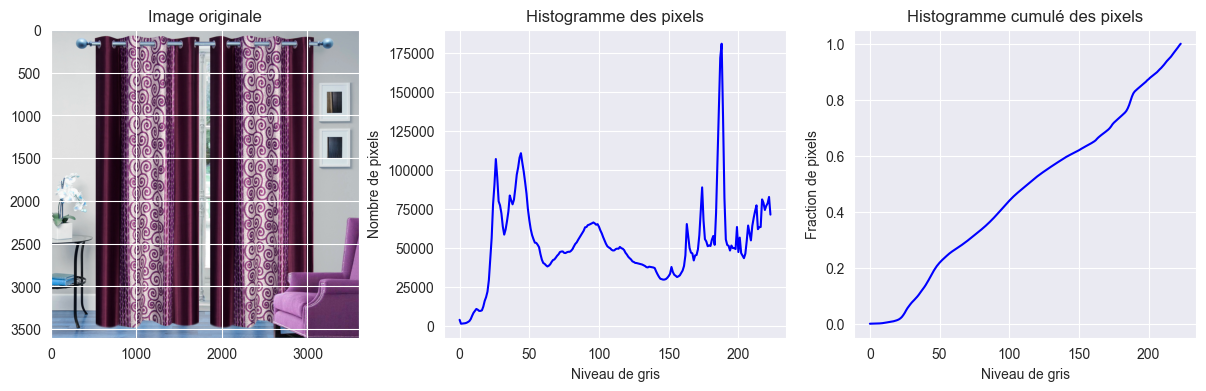

In [24]:
import cv2
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Chemin vers l'image prétraitée
image_path = '/Users/danongohou/Desktop/P6/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg'

# Charger l'image prétraitée avec OpenCV
img = cv2.imread(image_path, cv2.COLOR_BGR2RGB)



# Charger l'image
#image_path = '/Users/danongohou/Desktop/P6/Images/'
#img = cv2.imread(image_path + image_df['image'][0])


plt.figure(figsize=(15, 4))
sns.set_style('darkgrid')

# Afficher l'image
plt.subplot(1, 3, 1)
plt.imshow(img) #cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Image originale')

# Calculer l'histogramme des pixels
histogram = cv2.calcHist([img], [0], None, [224], [0, 224])

# Afficher l'histogramme des pixels
plt.subplot(1, 3, 2)
plt.plot(histogram, color='blue')
plt.xlabel('Niveau de gris')
plt.ylabel('Nombre de pixels')
plt.title('Histogramme des pixels')

# Calculer l'histogramme cumulé des pixels
cumulative_hist = np.cumsum(histogram)

# Normaliser l'histogramme cumulé pour le mettre à l'échelle de [0, 1]
cumulative_hist_norm = cumulative_hist / np.sum(histogram)

# Afficher l'histogramme cumulé des pixels
plt.subplot(1, 3, 3)
plt.plot(cumulative_hist_norm, color='blue')
plt.xlabel('Niveau de gris')
plt.ylabel('Fraction de pixels')
plt.title('Histogramme cumulé des pixels')

# Afficher les trois graphes côte à côte
plt.subplots_adjust(wspace=0.2)
plt.show()

### Image prétraitée et Histogramme des pixels

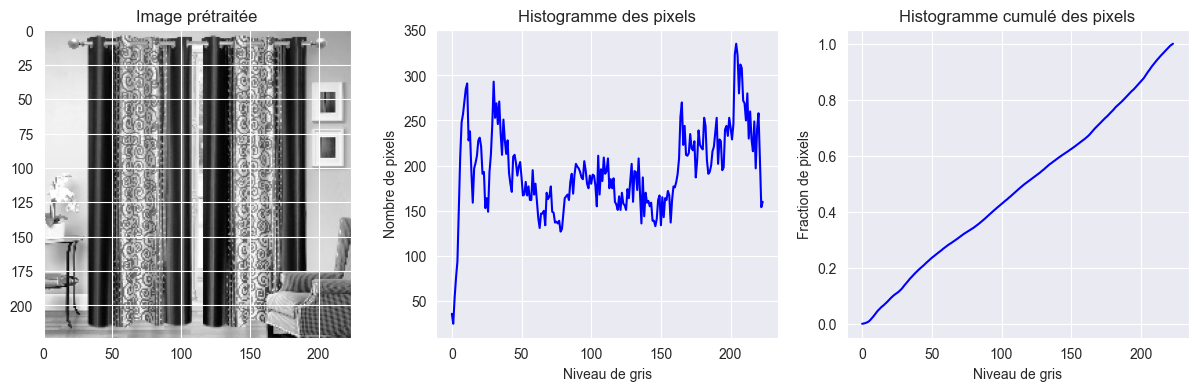

In [73]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Chemin vers l'image prétraitée
processed_image_path = '/Users/danongohou/Desktop/P6/Processed_Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg'

# Charger l'image prétraitée avec OpenCV
processed_image = cv2.imread(processed_image_path, cv2.IMREAD_GRAYSCALE)


plt.figure(figsize=(15, 4))
sns.set_style('darkgrid')

# Afficher l'image
plt.subplot(1, 3, 1)
plt.imshow(processed_image, cmap='gray')
plt.title('Image prétraitée')



# Calculer l'histogramme des pixels
histogram = cv2.calcHist([processed_image], [0], None, [224], [0, 224])

# Afficher l'histogramme des pixels
plt.subplot(1, 3, 2)
plt.plot(histogram, color='blue')
plt.xlabel('Niveau de gris')
plt.ylabel('Nombre de pixels')
plt.title('Histogramme des pixels')


# Calculer l'histogramme cumulé des pixels
cumulative_hist = np.cumsum(histogram)
# Normaliser l'histogramme cumulé pour le mettre à l'échelle de [0, 1]
cumulative_hist_norm = cumulative_hist / np.sum(histogram)

# Afficher l'histogramme cumulé des pixels
plt.subplot(1, 3, 3)
plt.plot(cumulative_hist_norm, color='blue')
plt.xlabel('Niveau de gris')
plt.ylabel('Fraction de pixels')
plt.title('Histogramme cumulé des pixels')

# Afficher les trois graphes côte à côte
plt.subplots_adjust(wspace=0.2)
plt.show()



# ORB

In [5]:
import pandas as pd 

data_image = pd.read_csv('image_df.csv')
data_image.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      1050 non-null   int64 
 1   image           1050 non-null   object
 2   Location_image  1050 non-null   object
 3   product_name    1050 non-null   object
 4   description     1050 non-null   object
 5   category        1050 non-null   object
dtypes: int64(1), object(5)
memory usage: 49.3+ KB


In [6]:
data_image.drop(columns=['Unnamed: 0', 'Location_image', 'product_name', 'description'], inplace=True)


In [7]:
 data_image.head()

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing


In [8]:
image_path = '/Users/danongohou/Desktop/P6/Processed_Images/'
data_image['image_loc'] = [image_path + row for row in data_image['image']]

In [9]:
data_image.head()

,image,category,image_loc
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,/Users/danongohou/Desktop/P6/Processed_Images/...
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,/Users/danongohou/Desktop/P6/Processed_Images/...
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,/Users/danongohou/Desktop/P6/Processed_Images/...
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,/Users/danongohou/Desktop/P6/Processed_Images/...
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,/Users/danongohou/Desktop/P6/Processed_Images/...


In [10]:
data_image.to_csv('data_image.csv')

- ## Extraction des features

In [11]:
import os
import cv2
import pickle
import numpy as np
from sklearn.cluster import KMeans

# Charger les images
images = []
for filename in os.listdir('/Users/danongohou/Desktop/P6/Processed_Images/'):
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):
        image = cv2.imread(os.path.join('/Users/danongohou/Desktop/P6/Processed_Images/', filename), cv2.IMREAD_GRAYSCALE)
        images.append(image)

# Extraire les descripteurs ORB
orb = cv2.ORB_create()
descripteurs = []
keypoints = []
for image in images:
    kp, des = orb.detectAndCompute(image, None)
    descripteurs.append(des)
    keypoints.append(kp)
orb_list_descripteurs = np.vstack(descripteurs)

print(f'{len(images)} images chargées')
print(f'{len(orb_list_descripteurs)} descripteurs extraits')

# Vérifie si le répertoire 'sauvegarde' existe, sinon le crée
if not os.path.exists('orb_files/'):
    os.makedirs('orb_files/')

# Ouvre un fichier binaire 'les_descripteurs/orb_list_descripteurs.pickle' en mode écriture binaire ('wb')
with open('orb_files/orb_list_descripteurs.pickle', 'wb') as f:
    # Sérialise l'objet Python 'orb_list_descripteurs' et l'écrit dans le fichier binaire ouvert
    pickle.dump(orb_list_descripteurs, f, pickle.HIGHEST_PROTOCOL)


1050 images chargées
394376 descripteurs extraits


- ## Création du dictionnaire de visual words

In [12]:
import numpy as np
import pickle
from sklearn.cluster import KMeans

# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/orb_list_descripteurs.pickle', 'rb') as f:
    orb_list_descripteurs = pickle.load(f)

# Appliquer la méthode k-means pour regrouper les descripteurs en clusters
orb_kmeans = KMeans(n_clusters=1000, n_init=10, random_state=0)
orb_kmeans.fit(orb_list_descripteurs)
visual_words = orb_kmeans.cluster_centers_

# Sauvegarder le dictionnaire de visual words dans un fichier pickle
with open('orb_files/visual_words.pickle', 'wb') as f:
    pickle.dump(orb_kmeans.cluster_centers_, f)


# Sauvegarde du modèle KMeans entraîné dans un fichier
with open('orb_files/orb_kmeans.pickle', 'wb') as f:
    pickle.dump(orb_kmeans, f)


In [13]:
np.save('orb_files/orb_list_descripteurs.npy', orb_list_descripteurs)
np.save('orb_files/visual_words.npy', visual_words)
np.save('orb_files/orb_kmeans.npy', orb_kmeans)


- ## Histogramme

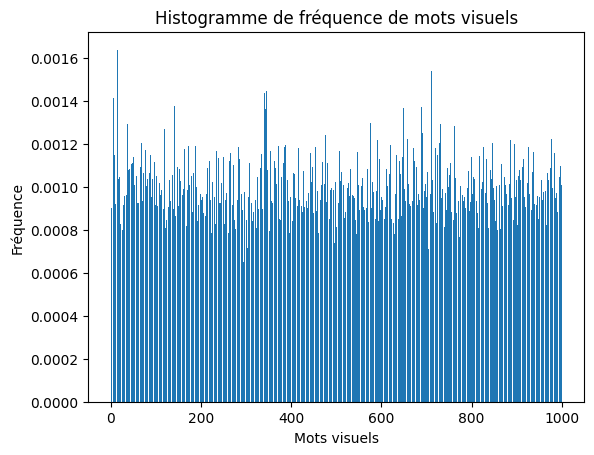

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/orb_list_descripteurs.pickle', 'rb') as f:
    orb_list_descripteurs = pickle.load(f)

# Charger le dictionnaire de mots visuels
with open('orb_files/visual_words.pickle', 'rb') as f:
    visual_words = pickle.load(f)
# Sauvegarde du modèle KMeans entraîné dans un fichier
with open('orb_files/orb_kmeans.pickle', 'rb') as f:
    orb_kmeans= pickle.load(f)
    
# Assigner chaque descripteur ORB à un mot visuel dans le dictionnaire
orb_descr_visual = orb_kmeans.predict(orb_list_descripteurs)

# Créer l'histogramme de fréquence de mots visuels
orb_hist, _ = np.histogram(orb_descr_visual, bins=len(visual_words), range=(0, len(visual_words)))
orb_hist = orb_hist.astype(float) / len(orb_list_descripteurs)

# Afficher l'histogramme
plt.bar(range(len(visual_words)), orb_hist)
plt.xlabel('Mots visuels')
plt.ylabel('Fréquence')
plt.title('Histogramme de fréquence de mots visuels')
plt.show()


### Dataframe de vecteurs des features issus de ORB

In [17]:
# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/orb_list_descripteurs.pickle', 'rb') as f:
    orb_list_descripteurs = pickle.load(f)
    
# Dataframe de vecteurs des features issus de ResNet152
df_features_vectors = pd.DataFrame.from_records(orb_list_descripteurs)

# Sauvegarde du dataframe des vectors BOVW ResNet152
with open('orb_files/df_features_vectors.pickle', 'wb') as f:
    pickle.dump(df_features_vectors, f, pickle.HIGHEST_PROTOCOL)


In [28]:
orb_list_descripteurs.shape

(394376, 32)

### PCA

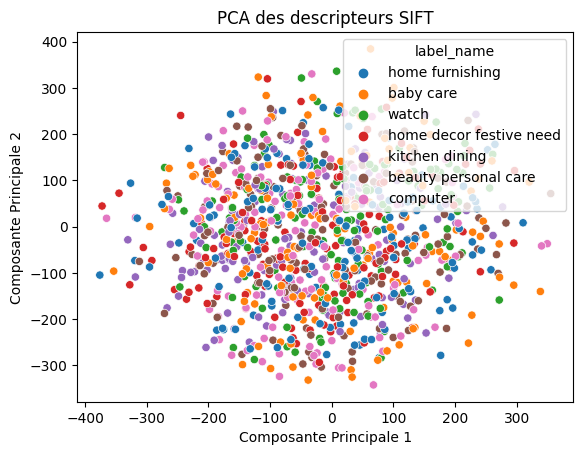

(394376, 32)
(394376, 18)


In [26]:
import pandas as pd
import cv2
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

# Charger les données de data_image.csv
df = pd.read_csv('data_image.csv')

# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/df_features_vectors.pickle', 'rb') as f:
    df_features_vectors = pickle.load(f)

# Appliquer une réduction de dimensionnalité avec PCA
pca = PCA(n_components=0.80)
descripteurs_pca = pca.fit_transform(df_features_vectors)

# Créer un dataframe pour les données du PCA
descriptors_pca_df = descripteurs_pca[:, [0, 1]]
descriptors_pca_df = pd.DataFrame(descriptors_pca_df, columns=["pc1", "pc2"])
descriptors_pca_df["label_name"] = df["category"]


# Afficher le graphique avec labels de catégorie
sns.scatterplot(data=descriptors_pca_df, x="pc1", y="pc2", hue="label_name")
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('PCA des descripteurs SIFT')
plt.show()


print(df_features_vectors.shape) 
print(descripteurs_pca.shape)

### Choix hyperparametres pour T-SNE

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/df_features_vectors.pickle', 'rb') as f:
    df_features_vectors = pickle.load(f)

    
liste_param = [20, 30, 40, 50, 70, 80]
results_resnet = list()
tsne_results = []
for i in liste_param:
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=500,random_state=42)
    tsne_results = tsne.fit_transform(df_features_vectors)
    results_resnet.append(tsne_results)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 394376 samples in 0.050s...
[t-SNE] Computed neighbors for 394376 samples in 255.214s...
[t-SNE] Computed conditional probabilities for sample 1000 / 394376
[t-SNE] Computed conditional probabilities for sample 2000 / 394376
[t-SNE] Computed conditional probabilities for sample 3000 / 394376
[t-SNE] Computed conditional probabilities for sample 4000 / 394376
[t-SNE] Computed conditional probabilities for sample 5000 / 394376
[t-SNE] Computed conditional probabilities for sample 6000 / 394376
[t-SNE] Computed conditional probabilities for sample 7000 / 394376
[t-SNE] Computed conditional probabilities for sample 8000 / 394376
[t-SNE] Computed conditional probabilities for sample 9000 / 394376
[t-SNE] Computed conditional probabilities for sample 10000 / 394376
[t-SNE] Computed conditional probabilities for sample 11000 / 394376
[t-SNE] Computed conditional probabilities for sample 12000 / 394376
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 119000 / 394376
[t-SNE] Computed conditional probabilities for sample 120000 / 394376
[t-SNE] Computed conditional probabilities for sample 121000 / 394376
[t-SNE] Computed conditional probabilities for sample 122000 / 394376
[t-SNE] Computed conditional probabilities for sample 123000 / 394376
[t-SNE] Computed conditional probabilities for sample 124000 / 394376
[t-SNE] Computed conditional probabilities for sample 125000 / 394376
[t-SNE] Computed conditional probabilities for sample 126000 / 394376
[t-SNE] Computed conditional probabilities for sample 127000 / 394376
[t-SNE] Computed conditional probabilities for sample 128000 / 394376
[t-SNE] Computed conditional probabilities for sample 129000 / 394376
[t-SNE] Computed conditional probabilities for sample 130000 / 394376
[t-SNE] Computed conditional probabilities for sample 131000 / 394376
[t-SNE] Computed conditional probabilities for sample 132000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 243000 / 394376
[t-SNE] Computed conditional probabilities for sample 244000 / 394376
[t-SNE] Computed conditional probabilities for sample 245000 / 394376
[t-SNE] Computed conditional probabilities for sample 246000 / 394376
[t-SNE] Computed conditional probabilities for sample 247000 / 394376
[t-SNE] Computed conditional probabilities for sample 248000 / 394376
[t-SNE] Computed conditional probabilities for sample 249000 / 394376
[t-SNE] Computed conditional probabilities for sample 250000 / 394376
[t-SNE] Computed conditional probabilities for sample 251000 / 394376
[t-SNE] Computed conditional probabilities for sample 252000 / 394376
[t-SNE] Computed conditional probabilities for sample 253000 / 394376
[t-SNE] Computed conditional probabilities for sample 254000 / 394376
[t-SNE] Computed conditional probabilities for sample 255000 / 394376
[t-SNE] Computed conditional probabilities for sample 256000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 366000 / 394376
[t-SNE] Computed conditional probabilities for sample 367000 / 394376
[t-SNE] Computed conditional probabilities for sample 368000 / 394376
[t-SNE] Computed conditional probabilities for sample 369000 / 394376
[t-SNE] Computed conditional probabilities for sample 370000 / 394376
[t-SNE] Computed conditional probabilities for sample 371000 / 394376
[t-SNE] Computed conditional probabilities for sample 372000 / 394376
[t-SNE] Computed conditional probabilities for sample 373000 / 394376
[t-SNE] Computed conditional probabilities for sample 374000 / 394376
[t-SNE] Computed conditional probabilities for sample 375000 / 394376
[t-SNE] Computed conditional probabilities for sample 376000 / 394376
[t-SNE] Computed conditional probabilities for sample 377000 / 394376
[t-SNE] Computed conditional probabilities for sample 378000 / 394376
[t-SNE] Computed conditional probabilities for sample 379000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 88000 / 394376
[t-SNE] Computed conditional probabilities for sample 89000 / 394376
[t-SNE] Computed conditional probabilities for sample 90000 / 394376
[t-SNE] Computed conditional probabilities for sample 91000 / 394376
[t-SNE] Computed conditional probabilities for sample 92000 / 394376
[t-SNE] Computed conditional probabilities for sample 93000 / 394376
[t-SNE] Computed conditional probabilities for sample 94000 / 394376
[t-SNE] Computed conditional probabilities for sample 95000 / 394376
[t-SNE] Computed conditional probabilities for sample 96000 / 394376
[t-SNE] Computed conditional probabilities for sample 97000 / 394376
[t-SNE] Computed conditional probabilities for sample 98000 / 394376
[t-SNE] Computed conditional probabilities for sample 99000 / 394376
[t-SNE] Computed conditional probabilities for sample 100000 / 394376
[t-SNE] Computed conditional probabilities for sample 101000 / 394376
[t-SNE] Computed conditional pro

[t-SNE] Computed conditional probabilities for sample 211000 / 394376
[t-SNE] Computed conditional probabilities for sample 212000 / 394376
[t-SNE] Computed conditional probabilities for sample 213000 / 394376
[t-SNE] Computed conditional probabilities for sample 214000 / 394376
[t-SNE] Computed conditional probabilities for sample 215000 / 394376
[t-SNE] Computed conditional probabilities for sample 216000 / 394376
[t-SNE] Computed conditional probabilities for sample 217000 / 394376
[t-SNE] Computed conditional probabilities for sample 218000 / 394376
[t-SNE] Computed conditional probabilities for sample 219000 / 394376
[t-SNE] Computed conditional probabilities for sample 220000 / 394376
[t-SNE] Computed conditional probabilities for sample 221000 / 394376
[t-SNE] Computed conditional probabilities for sample 222000 / 394376
[t-SNE] Computed conditional probabilities for sample 223000 / 394376
[t-SNE] Computed conditional probabilities for sample 224000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 333000 / 394376
[t-SNE] Computed conditional probabilities for sample 334000 / 394376
[t-SNE] Computed conditional probabilities for sample 335000 / 394376
[t-SNE] Computed conditional probabilities for sample 336000 / 394376
[t-SNE] Computed conditional probabilities for sample 337000 / 394376
[t-SNE] Computed conditional probabilities for sample 338000 / 394376
[t-SNE] Computed conditional probabilities for sample 339000 / 394376
[t-SNE] Computed conditional probabilities for sample 340000 / 394376
[t-SNE] Computed conditional probabilities for sample 341000 / 394376
[t-SNE] Computed conditional probabilities for sample 342000 / 394376
[t-SNE] Computed conditional probabilities for sample 343000 / 394376
[t-SNE] Computed conditional probabilities for sample 344000 / 394376
[t-SNE] Computed conditional probabilities for sample 345000 / 394376
[t-SNE] Computed conditional probabilities for sample 346000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 55000 / 394376
[t-SNE] Computed conditional probabilities for sample 56000 / 394376
[t-SNE] Computed conditional probabilities for sample 57000 / 394376
[t-SNE] Computed conditional probabilities for sample 58000 / 394376
[t-SNE] Computed conditional probabilities for sample 59000 / 394376
[t-SNE] Computed conditional probabilities for sample 60000 / 394376
[t-SNE] Computed conditional probabilities for sample 61000 / 394376
[t-SNE] Computed conditional probabilities for sample 62000 / 394376
[t-SNE] Computed conditional probabilities for sample 63000 / 394376
[t-SNE] Computed conditional probabilities for sample 64000 / 394376
[t-SNE] Computed conditional probabilities for sample 65000 / 394376
[t-SNE] Computed conditional probabilities for sample 66000 / 394376
[t-SNE] Computed conditional probabilities for sample 67000 / 394376
[t-SNE] Computed conditional probabilities for sample 68000 / 394376
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 181000 / 394376
[t-SNE] Computed conditional probabilities for sample 182000 / 394376
[t-SNE] Computed conditional probabilities for sample 183000 / 394376
[t-SNE] Computed conditional probabilities for sample 184000 / 394376
[t-SNE] Computed conditional probabilities for sample 185000 / 394376
[t-SNE] Computed conditional probabilities for sample 186000 / 394376
[t-SNE] Computed conditional probabilities for sample 187000 / 394376
[t-SNE] Computed conditional probabilities for sample 188000 / 394376
[t-SNE] Computed conditional probabilities for sample 189000 / 394376
[t-SNE] Computed conditional probabilities for sample 190000 / 394376
[t-SNE] Computed conditional probabilities for sample 191000 / 394376
[t-SNE] Computed conditional probabilities for sample 192000 / 394376
[t-SNE] Computed conditional probabilities for sample 193000 / 394376
[t-SNE] Computed conditional probabilities for sample 194000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 306000 / 394376
[t-SNE] Computed conditional probabilities for sample 307000 / 394376
[t-SNE] Computed conditional probabilities for sample 308000 / 394376
[t-SNE] Computed conditional probabilities for sample 309000 / 394376
[t-SNE] Computed conditional probabilities for sample 310000 / 394376
[t-SNE] Computed conditional probabilities for sample 311000 / 394376
[t-SNE] Computed conditional probabilities for sample 312000 / 394376
[t-SNE] Computed conditional probabilities for sample 313000 / 394376
[t-SNE] Computed conditional probabilities for sample 314000 / 394376
[t-SNE] Computed conditional probabilities for sample 315000 / 394376
[t-SNE] Computed conditional probabilities for sample 316000 / 394376
[t-SNE] Computed conditional probabilities for sample 317000 / 394376
[t-SNE] Computed conditional probabilities for sample 318000 / 394376
[t-SNE] Computed conditional probabilities for sample 319000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 30000 / 394376
[t-SNE] Computed conditional probabilities for sample 31000 / 394376
[t-SNE] Computed conditional probabilities for sample 32000 / 394376
[t-SNE] Computed conditional probabilities for sample 33000 / 394376
[t-SNE] Computed conditional probabilities for sample 34000 / 394376
[t-SNE] Computed conditional probabilities for sample 35000 / 394376
[t-SNE] Computed conditional probabilities for sample 36000 / 394376
[t-SNE] Computed conditional probabilities for sample 37000 / 394376
[t-SNE] Computed conditional probabilities for sample 38000 / 394376
[t-SNE] Computed conditional probabilities for sample 39000 / 394376
[t-SNE] Computed conditional probabilities for sample 40000 / 394376
[t-SNE] Computed conditional probabilities for sample 41000 / 394376
[t-SNE] Computed conditional probabilities for sample 42000 / 394376
[t-SNE] Computed conditional probabilities for sample 43000 / 394376
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 153000 / 394376
[t-SNE] Computed conditional probabilities for sample 154000 / 394376
[t-SNE] Computed conditional probabilities for sample 155000 / 394376
[t-SNE] Computed conditional probabilities for sample 156000 / 394376
[t-SNE] Computed conditional probabilities for sample 157000 / 394376
[t-SNE] Computed conditional probabilities for sample 158000 / 394376
[t-SNE] Computed conditional probabilities for sample 159000 / 394376
[t-SNE] Computed conditional probabilities for sample 160000 / 394376
[t-SNE] Computed conditional probabilities for sample 161000 / 394376
[t-SNE] Computed conditional probabilities for sample 162000 / 394376
[t-SNE] Computed conditional probabilities for sample 163000 / 394376
[t-SNE] Computed conditional probabilities for sample 164000 / 394376
[t-SNE] Computed conditional probabilities for sample 165000 / 394376
[t-SNE] Computed conditional probabilities for sample 166000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 275000 / 394376
[t-SNE] Computed conditional probabilities for sample 276000 / 394376
[t-SNE] Computed conditional probabilities for sample 277000 / 394376
[t-SNE] Computed conditional probabilities for sample 278000 / 394376
[t-SNE] Computed conditional probabilities for sample 279000 / 394376
[t-SNE] Computed conditional probabilities for sample 280000 / 394376
[t-SNE] Computed conditional probabilities for sample 281000 / 394376
[t-SNE] Computed conditional probabilities for sample 282000 / 394376
[t-SNE] Computed conditional probabilities for sample 283000 / 394376
[t-SNE] Computed conditional probabilities for sample 284000 / 394376
[t-SNE] Computed conditional probabilities for sample 285000 / 394376
[t-SNE] Computed conditional probabilities for sample 286000 / 394376
[t-SNE] Computed conditional probabilities for sample 287000 / 394376
[t-SNE] Computed conditional probabilities for sample 288000 / 394376
[t-SNE] Computed con

[t-SNE] KL divergence after 250 iterations with early exaggeration: 127.872818
[t-SNE] KL divergence after 500 iterations: 5.828877
[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 394376 samples in 0.047s...
[t-SNE] Computed neighbors for 394376 samples in 282.203s...
[t-SNE] Computed conditional probabilities for sample 1000 / 394376
[t-SNE] Computed conditional probabilities for sample 2000 / 394376
[t-SNE] Computed conditional probabilities for sample 3000 / 394376
[t-SNE] Computed conditional probabilities for sample 4000 / 394376
[t-SNE] Computed conditional probabilities for sample 5000 / 394376
[t-SNE] Computed conditional probabilities for sample 6000 / 394376
[t-SNE] Computed conditional probabilities for sample 7000 / 394376
[t-SNE] Computed conditional probabilities for sample 8000 / 394376
[t-SNE] Computed conditional probabilities for sample 9000 / 394376
[t-SNE] Computed conditional probabilities for sample 10000 / 394376
[t-SNE] Computed conditional probabilit

[t-SNE] Computed conditional probabilities for sample 123000 / 394376
[t-SNE] Computed conditional probabilities for sample 124000 / 394376
[t-SNE] Computed conditional probabilities for sample 125000 / 394376
[t-SNE] Computed conditional probabilities for sample 126000 / 394376
[t-SNE] Computed conditional probabilities for sample 127000 / 394376
[t-SNE] Computed conditional probabilities for sample 128000 / 394376
[t-SNE] Computed conditional probabilities for sample 129000 / 394376
[t-SNE] Computed conditional probabilities for sample 130000 / 394376
[t-SNE] Computed conditional probabilities for sample 131000 / 394376
[t-SNE] Computed conditional probabilities for sample 132000 / 394376
[t-SNE] Computed conditional probabilities for sample 133000 / 394376
[t-SNE] Computed conditional probabilities for sample 134000 / 394376
[t-SNE] Computed conditional probabilities for sample 135000 / 394376
[t-SNE] Computed conditional probabilities for sample 136000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 241000 / 394376
[t-SNE] Computed conditional probabilities for sample 242000 / 394376
[t-SNE] Computed conditional probabilities for sample 243000 / 394376
[t-SNE] Computed conditional probabilities for sample 244000 / 394376
[t-SNE] Computed conditional probabilities for sample 245000 / 394376
[t-SNE] Computed conditional probabilities for sample 246000 / 394376
[t-SNE] Computed conditional probabilities for sample 247000 / 394376
[t-SNE] Computed conditional probabilities for sample 248000 / 394376
[t-SNE] Computed conditional probabilities for sample 249000 / 394376
[t-SNE] Computed conditional probabilities for sample 250000 / 394376
[t-SNE] Computed conditional probabilities for sample 251000 / 394376
[t-SNE] Computed conditional probabilities for sample 252000 / 394376
[t-SNE] Computed conditional probabilities for sample 253000 / 394376
[t-SNE] Computed conditional probabilities for sample 254000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 367000 / 394376
[t-SNE] Computed conditional probabilities for sample 368000 / 394376
[t-SNE] Computed conditional probabilities for sample 369000 / 394376
[t-SNE] Computed conditional probabilities for sample 370000 / 394376
[t-SNE] Computed conditional probabilities for sample 371000 / 394376
[t-SNE] Computed conditional probabilities for sample 372000 / 394376
[t-SNE] Computed conditional probabilities for sample 373000 / 394376
[t-SNE] Computed conditional probabilities for sample 374000 / 394376
[t-SNE] Computed conditional probabilities for sample 375000 / 394376
[t-SNE] Computed conditional probabilities for sample 376000 / 394376
[t-SNE] Computed conditional probabilities for sample 377000 / 394376
[t-SNE] Computed conditional probabilities for sample 378000 / 394376
[t-SNE] Computed conditional probabilities for sample 379000 / 394376
[t-SNE] Computed conditional probabilities for sample 380000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 90000 / 394376
[t-SNE] Computed conditional probabilities for sample 91000 / 394376
[t-SNE] Computed conditional probabilities for sample 92000 / 394376
[t-SNE] Computed conditional probabilities for sample 93000 / 394376
[t-SNE] Computed conditional probabilities for sample 94000 / 394376
[t-SNE] Computed conditional probabilities for sample 95000 / 394376
[t-SNE] Computed conditional probabilities for sample 96000 / 394376
[t-SNE] Computed conditional probabilities for sample 97000 / 394376
[t-SNE] Computed conditional probabilities for sample 98000 / 394376
[t-SNE] Computed conditional probabilities for sample 99000 / 394376
[t-SNE] Computed conditional probabilities for sample 100000 / 394376
[t-SNE] Computed conditional probabilities for sample 101000 / 394376
[t-SNE] Computed conditional probabilities for sample 102000 / 394376
[t-SNE] Computed conditional probabilities for sample 103000 / 394376
[t-SNE] Computed conditional p

[t-SNE] Computed conditional probabilities for sample 216000 / 394376
[t-SNE] Computed conditional probabilities for sample 217000 / 394376
[t-SNE] Computed conditional probabilities for sample 218000 / 394376
[t-SNE] Computed conditional probabilities for sample 219000 / 394376
[t-SNE] Computed conditional probabilities for sample 220000 / 394376
[t-SNE] Computed conditional probabilities for sample 221000 / 394376
[t-SNE] Computed conditional probabilities for sample 222000 / 394376
[t-SNE] Computed conditional probabilities for sample 223000 / 394376
[t-SNE] Computed conditional probabilities for sample 224000 / 394376
[t-SNE] Computed conditional probabilities for sample 225000 / 394376
[t-SNE] Computed conditional probabilities for sample 226000 / 394376
[t-SNE] Computed conditional probabilities for sample 227000 / 394376
[t-SNE] Computed conditional probabilities for sample 228000 / 394376
[t-SNE] Computed conditional probabilities for sample 229000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 341000 / 394376
[t-SNE] Computed conditional probabilities for sample 342000 / 394376
[t-SNE] Computed conditional probabilities for sample 343000 / 394376
[t-SNE] Computed conditional probabilities for sample 344000 / 394376
[t-SNE] Computed conditional probabilities for sample 345000 / 394376
[t-SNE] Computed conditional probabilities for sample 346000 / 394376
[t-SNE] Computed conditional probabilities for sample 347000 / 394376
[t-SNE] Computed conditional probabilities for sample 348000 / 394376
[t-SNE] Computed conditional probabilities for sample 349000 / 394376
[t-SNE] Computed conditional probabilities for sample 350000 / 394376
[t-SNE] Computed conditional probabilities for sample 351000 / 394376
[t-SNE] Computed conditional probabilities for sample 352000 / 394376
[t-SNE] Computed conditional probabilities for sample 353000 / 394376
[t-SNE] Computed conditional probabilities for sample 354000 / 394376
[t-SNE] Computed con

### Plot Plusieurs resultats TSNE

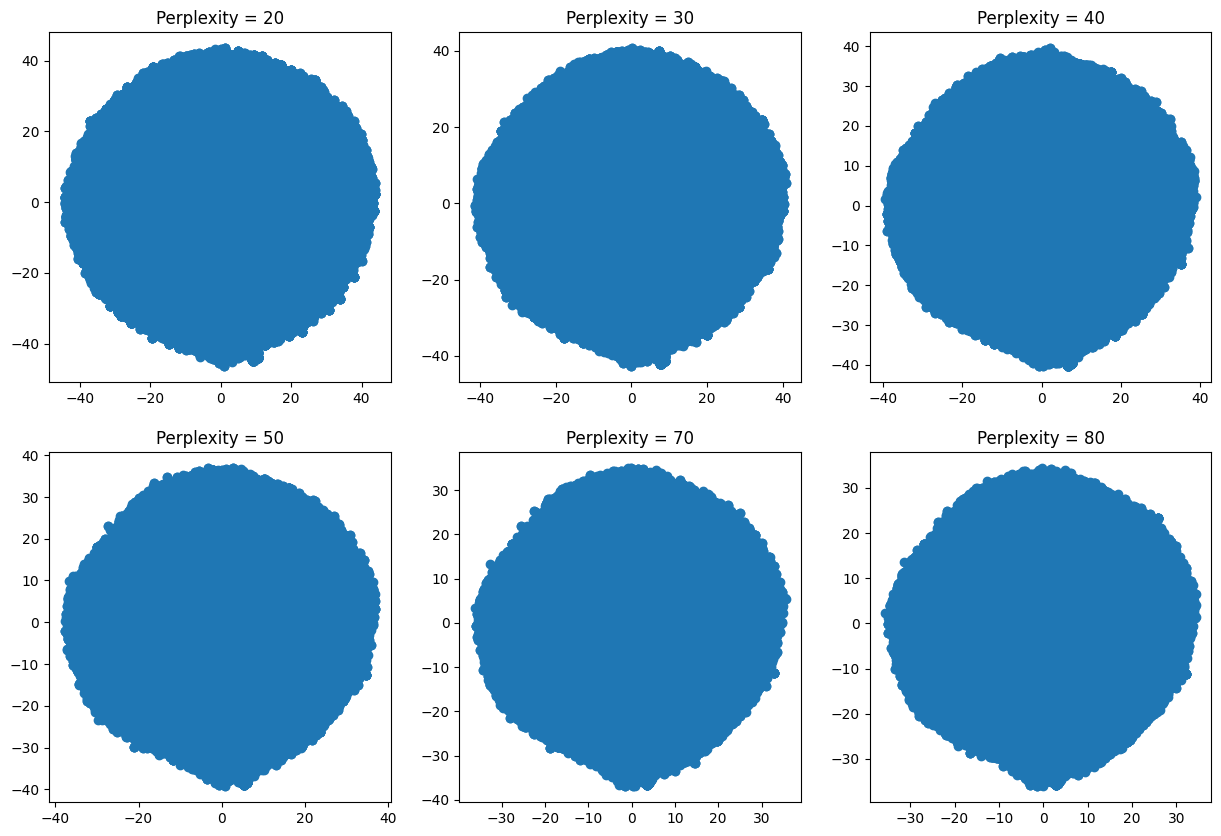

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, perplexity in enumerate(liste_param):
    row = i // 3
    col = i % 3
    axs[row, col].scatter(results_resnet[i][:, 0], results_resnet[i][:, 1])
    axs[row, col].set_title(f"Perplexity = {perplexity}")
plt.show()

### T-SNE

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/df_features_vectors.pickle', 'rb') as f:
    df_features_vectors = pickle.load(f)

# Charger les données de data_image.csv
df = pd.read_csv('data_image.csv')

# Réduction de dimension tsne
tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=500)
orb_tsne = tsne.fit_transform(df_features_vectors)


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 394376 samples in 0.051s...
[t-SNE] Computed neighbors for 394376 samples in 274.771s...
[t-SNE] Computed conditional probabilities for sample 1000 / 394376
[t-SNE] Computed conditional probabilities for sample 2000 / 394376
[t-SNE] Computed conditional probabilities for sample 3000 / 394376
[t-SNE] Computed conditional probabilities for sample 4000 / 394376
[t-SNE] Computed conditional probabilities for sample 5000 / 394376
[t-SNE] Computed conditional probabilities for sample 6000 / 394376
[t-SNE] Computed conditional probabilities for sample 7000 / 394376
[t-SNE] Computed conditional probabilities for sample 8000 / 394376
[t-SNE] Computed conditional probabilities for sample 9000 / 394376
[t-SNE] Computed conditional probabilities for sample 10000 / 394376
[t-SNE] Computed conditional probabilities for sample 11000 / 394376
[t-SNE] Computed conditional probabilities for sample 12000 / 394376
[t-SNE] Computed conditional prob

[t-SNE] Computed conditional probabilities for sample 127000 / 394376
[t-SNE] Computed conditional probabilities for sample 128000 / 394376
[t-SNE] Computed conditional probabilities for sample 129000 / 394376
[t-SNE] Computed conditional probabilities for sample 130000 / 394376
[t-SNE] Computed conditional probabilities for sample 131000 / 394376
[t-SNE] Computed conditional probabilities for sample 132000 / 394376
[t-SNE] Computed conditional probabilities for sample 133000 / 394376
[t-SNE] Computed conditional probabilities for sample 134000 / 394376
[t-SNE] Computed conditional probabilities for sample 135000 / 394376
[t-SNE] Computed conditional probabilities for sample 136000 / 394376
[t-SNE] Computed conditional probabilities for sample 137000 / 394376
[t-SNE] Computed conditional probabilities for sample 138000 / 394376
[t-SNE] Computed conditional probabilities for sample 139000 / 394376
[t-SNE] Computed conditional probabilities for sample 140000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 247000 / 394376
[t-SNE] Computed conditional probabilities for sample 248000 / 394376
[t-SNE] Computed conditional probabilities for sample 249000 / 394376
[t-SNE] Computed conditional probabilities for sample 250000 / 394376
[t-SNE] Computed conditional probabilities for sample 251000 / 394376
[t-SNE] Computed conditional probabilities for sample 252000 / 394376
[t-SNE] Computed conditional probabilities for sample 253000 / 394376
[t-SNE] Computed conditional probabilities for sample 254000 / 394376
[t-SNE] Computed conditional probabilities for sample 255000 / 394376
[t-SNE] Computed conditional probabilities for sample 256000 / 394376
[t-SNE] Computed conditional probabilities for sample 257000 / 394376
[t-SNE] Computed conditional probabilities for sample 258000 / 394376
[t-SNE] Computed conditional probabilities for sample 259000 / 394376
[t-SNE] Computed conditional probabilities for sample 260000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 373000 / 394376
[t-SNE] Computed conditional probabilities for sample 374000 / 394376
[t-SNE] Computed conditional probabilities for sample 375000 / 394376
[t-SNE] Computed conditional probabilities for sample 376000 / 394376
[t-SNE] Computed conditional probabilities for sample 377000 / 394376
[t-SNE] Computed conditional probabilities for sample 378000 / 394376
[t-SNE] Computed conditional probabilities for sample 379000 / 394376
[t-SNE] Computed conditional probabilities for sample 380000 / 394376
[t-SNE] Computed conditional probabilities for sample 381000 / 394376
[t-SNE] Computed conditional probabilities for sample 382000 / 394376
[t-SNE] Computed conditional probabilities for sample 383000 / 394376
[t-SNE] Computed conditional probabilities for sample 384000 / 394376
[t-SNE] Computed conditional probabilities for sample 385000 / 394376
[t-SNE] Computed conditional probabilities for sample 386000 / 394376
[t-SNE] Computed con

NameError: name 'data' is not defined

<Figure size 1000x800 with 0 Axes>

In [41]:
import pickle
# Sauvegarde du dataframe des vectors BOVW ResNet152
with open('orb_files/orb_tsne.pickle', 'wb') as f:
    pickle.dump(orb_tsne, f, pickle.HIGHEST_PROTOCOL)
    

### DataFrame TSNE

In [48]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder

# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/orb_tsne.pickle', 'rb') as f:
    orb_tsne = pickle.load(f)
    
# Charger les données de data_image.csv
df = pd.read_csv('data_image.csv')

tsne_df  = pd.DataFrame(orb_tsne, columns=['tsne1', 'tsne2'])

# Fusionner les DataFrames
tsne_df = tsne_df.merge(df[["category", "image", "image_loc"]], 
                                                left_index=True, right_index=True)


enc = LabelEncoder()
tsne_df["label"] = enc.fit_transform(tsne_df["category"])
labels_true = tsne_df["label"]

import pickle
# Sauvegarde du dataframe des vectors BOVW ResNet152
with open('orb_files/tsne_df.pickle', 'wb') as f:
    pickle.dump(tsne_df, f, pickle.HIGHEST_PROTOCOL)

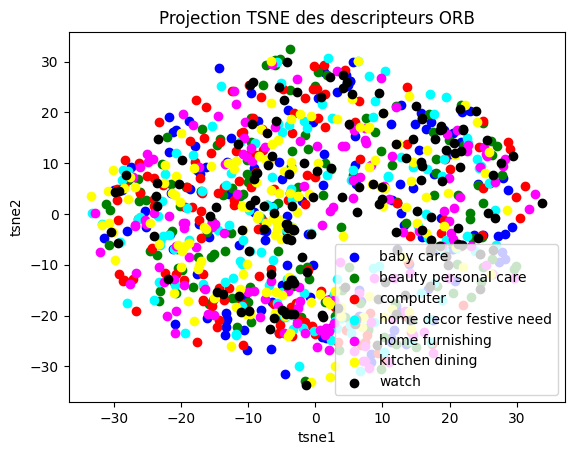

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger les données de data_image.csv
df = pd.read_csv('data_image.csv')

# Ajouter la colonne color_labels au dataframe df
color_labels = df['category']
df['category'] = color_labels

# Tracer le nuage de points avec 7 couleurs différentes
fig, ax = plt.subplots()
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
for i, label in enumerate(np.unique(color_labels)):
    idx = np.where(color_labels == label)
    ax.scatter(orb_tsne[idx, 0], orb_tsne[idx, 1], c=colors[i], label=label)
ax.legend()
plt.title("Projection TSNE des descripteurs ORB")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.show()

### KMEANS

In [54]:
import pickle

# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/tsne_df.pickle', 'rb') as f:
    tsne_df = pickle.load(f)

In [55]:
tsne_df.head() 

,tsne1,tsne2,category,image,image_loc,label
0,-10.050472,-15.375946,home furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,4
1,-3.679364,-2.538115,baby care,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,0
2,-4.950315,-13.991191,baby care,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,0
3,15.398124,-3.366631,home furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,4
4,-6.673257,-13.167905,home furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,4


In [79]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster, metrics
from sklearn.cluster import KMeans

tsne_df_copy = tsne_df.copy()

# Instanciation du modèle KMeans avec les meilleurs paramètres
cols = ['tsne1', 'tsne2']

kmeans_tsne = KMeans(n_clusters=7, init='k-means++', 
                     n_init=10, max_iter=200, random_state=42).fit(tsne_df_copy[cols])

# Ajout de l'assignation du cluster au dataframe
tsne_df_copy['kmeans_labels'] = kmeans_tsne.labels_

tsne_df_copy.head()

,tsne1,tsne2,category,image,image_loc,label,kmeans_labels
0,-10.050472,-15.375946,home furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,4,2
1,-3.679364,-2.538115,baby care,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,0,4
2,-4.950315,-13.991191,baby care,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,0,2
3,15.398124,-3.366631,home furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,4,5
4,-6.673257,-13.167905,home furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,4,2


### Fonction de mapping entre clusters obetenus avec les vraies catégories

In [81]:
# Function to map predicted labels to true category names
def get_named_labels_and_num_to_name(pred_labels, true_categ_names_list):
    label_num_to_name = {} # Créer un dictionnaire vide pour stocker les noms de catégorie réelle correspondants aux labels prédits

    for pred_label in sorted(set(pred_labels)): # Boucle pour chaque label prédit unique dans la liste de labels prédits
        # Extraction des indices des éléments correspondants à ce label dans la liste "pred_labels"
        indices = [i for i in range(len(pred_labels)) if pred_labels[i] == pred_label] 

        # Extraction des noms de catégories réelles correspondants aux indices dans la liste "true_categ_names_list"
        categ_names = [true_categ_names_list[i] for i in indices] 

        # Création d'une série Pandas avec les noms de catégories réelles extraits, 
        # puis utilisation de la méthode "value_counts()" pour obtenir le nombre d'occurrences de chaque nom de catégorie réelle
        categ_name_counts = pd.Series(categ_names).value_counts() 

        # Utilisation de la méthode "idxmax()" pour obtenir le nom de catégorie réelle le plus fréquent dans la série
        most_common_categ_name = categ_name_counts.idxmax() 

        # Stockage du label prédit et du nom de catégorie réelle correspondant dans le dictionnaire "label_num_to_name"
        label_num_to_name[pred_label] = most_common_categ_name

        # Remplacement de chaque occurrence du label prédit par le nom de catégorie réelle correspondant dans la liste "pred_labels"
        pred_labels = [x if x != pred_label else most_common_categ_name for x in pred_labels]

    return label_num_to_name # Renvoi du dictionnaire "label_num_to_name" qui mappe les labels prédits aux noms de catégories réelles correspondantes


categ_names = tsne_df_copy["category"]
predicted_labels = tsne_df_copy['kmeans_labels']

label_num_to_name = get_named_labels_and_num_to_name(predicted_labels, categ_names)
label_num_to_name


{0: 'computer',
 1: 'watch',
 2: 'computer',
 3: 'computer',
 4: 'kitchen dining',
 5: 'watch',
 6: 'home furnishing'}

In [82]:
df = {'computer': '0',
      'watch': '1', 
      'computer': '2', 
      'computer': '3', 
      'kitchen dining': '4', 
      'watch': '5',
      'home furnishing': '6'}

tsne_df_copy['true_labels'] = tsne_df_copy['category'].map(df)

In [83]:
tsne_df_copy.head()

,tsne1,tsne2,category,image,image_loc,label,kmeans_labels,true_labels
0,-10.050472,-15.375946,home furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,4,2,6
1,-3.679364,-2.538115,baby care,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,0,4,NaN
2,-4.950315,-13.991191,baby care,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,0,2,NaN
3,15.398124,-3.366631,home furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,4,5,6
4,-6.673257,-13.167905,home furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,4,2,6


In [84]:
tsne_df_copy['true_labels'].fillna('', inplace=True)


In [85]:
tsne_df_copy.head()

,tsne1,tsne2,category,image,image_loc,label,kmeans_labels,true_labels
0,-10.050472,-15.375946,home furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,4,2,6
1,-3.679364,-2.538115,baby care,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,0,4,
2,-4.950315,-13.991191,baby care,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,0,2,
3,15.398124,-3.366631,home furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,4,5,6
4,-6.673257,-13.167905,home furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6/Processed_Images/...,4,2,6


### Graph TSNE selon les vraies catégories

/var/folders/__/sl6gcy7s7r9d0cg0vj7xhw800000gn/T/ipykernel_937/2031994671.py:7: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(


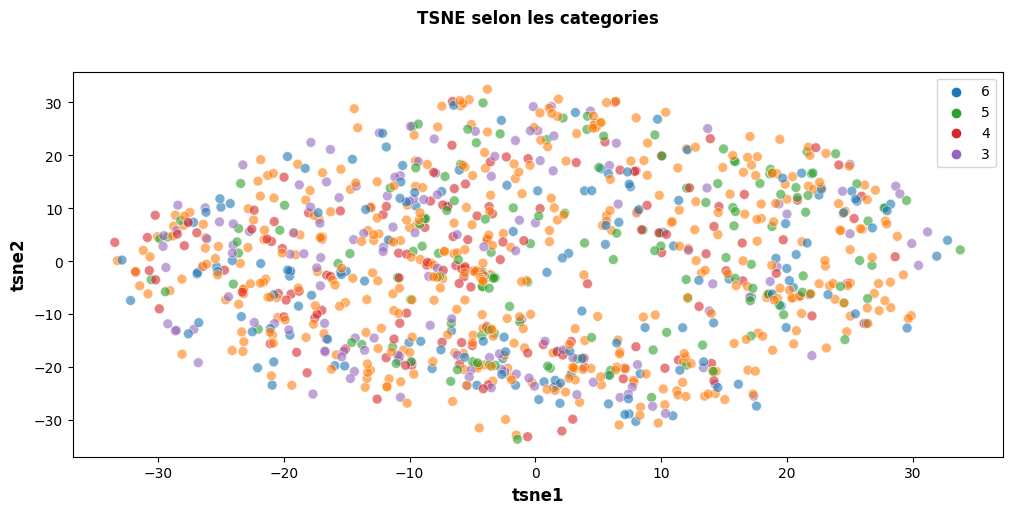

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="true_labels",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=tsne_df_copy,
    legend="brief")

plt.title('TSNE selon les categories', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

- **Baby care, Beauty and Personal Care, Home Decor & Festive Needs are missing**

- ### Kmeans

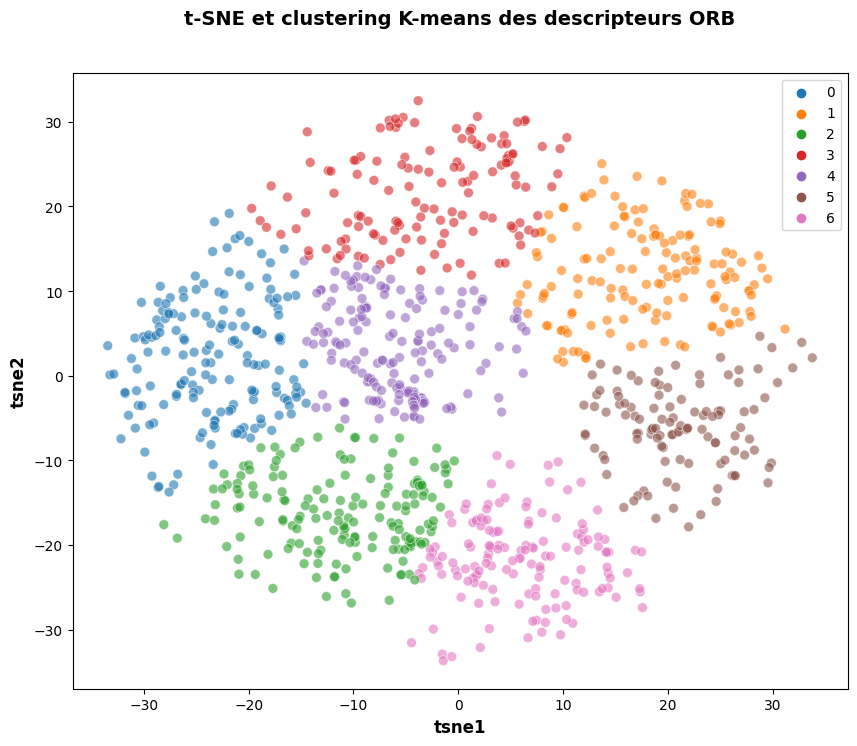

In [87]:
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster, metrics
from sklearn.cluster import KMeans

plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="kmeans_labels",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=tsne_df_copy,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.title('t-SNE et clustering K-means des descripteurs ORB', fontsize = 14, pad = 35, fontweight = 'bold')

plt.legend(prop={'size': 10}) 

plt.show()


In [88]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score

# Calculer le score ARI

labels = tsne_df_copy["true_labels"]
kmeans_labels = tsne_df_copy["kmeans_labels"] 

ari = adjusted_rand_score(labels, kmeans_labels)
print("Score ARI: {:.6f}".format(ari))

Score ARI: 0.001296
